In [1]:
import place_stimulation as ps
import visualstimulation as vs
import expipe

In [2]:
project_path = "/home/alessiob/Documents/Codes/expipe/projects/testing"

project = expipe.get_project(project_path)
actions = project.actions

In [3]:
actions

In [4]:
action = actions['1825-300119-1']

In [5]:
data_path = ps.get_data_path(action)

/home/alessiob/Documents/Codes/expipe/projects/testing
actions/1825-300119-1/data/main.exdir


In [6]:
epochs = ps.load_epochs(data_path)

In [7]:
channel_idx = 0
sptr = ps.load_spiketrains(data_path, channel_idx)

In [8]:
[print(ep.annotations) for ep in epochs]

{'node_id': 100, 'lazy_shape': None, 'processor': 'rhythm_fpga', 'provenance': 'open-ephys', 'exdir_path': '/epochs/open-ephys-epochs/rhythm_fpga_100'}
{'lazy_shape': None, 'provenance': 'psychopy', 'exdir_path': '/epochs/psychopy'}


[None, None]

In [9]:
oe_epoch = epochs[0]
ps_epoch = epochs[1]

In [10]:
orients = ps_epoch.labels
print(orients)

[135.   0. 315. 180. 270.  45.  90. 225.   0. 180.  90. 225. 315.  45.
 135. 270.  45. 315.   0. 270. 180.  90. 225. 135. 315. 270.   0. 225.
 135.  90.  45. 180. 315. 180. 270. 225.  45.  90.   0. 135.  90. 180.
   0. 225. 135. 315. 270.  45. 270.  45.   0. 225. 135.  90. 180. 315.
  90. 315. 180. 270. 135.  45. 225.   0. 225. 180.  45.   0.  90. 135.
 315. 270.  90.   0. 135. 270.  45. 225. 180. 315. 225. 270.  90. 315.
   0. 180.  45. 135. 270.  90. 225. 315.  45. 135.   0. 180.] deg


In [11]:
# make trials 
trials = vs.make_spiketrain_trials(sptr[1], oe_epoch)

In [12]:
vs.add_orientation_to_trials(trials, orients)
print(trials[0].annotations)

{'orient': array(135.) * deg}


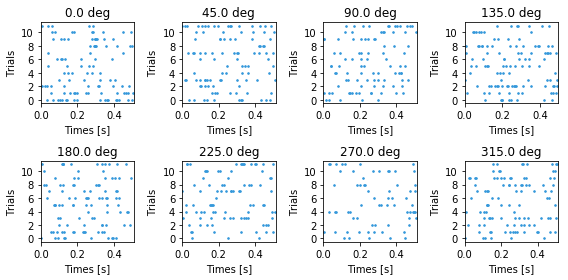

In [13]:
fig = vs.orient_raster_plots(trials)

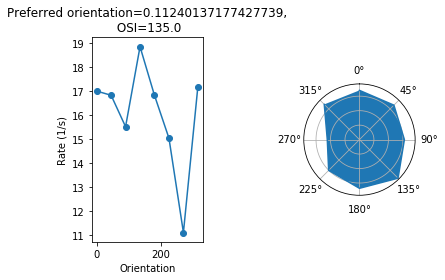

In [14]:
fig = vs.plot_tuning_overview(trials)